In [1]:
%load_ext cython
%matplotlib inline
import sys
sys.path.append('/home/bram/ANTS')
sys.path.append('/home/bram/ANTS/entropy')
for p in sys.path:
    print(p)


/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/home/bram/PythonEnvs/Ants/lib/python3.6/site-packages
/home/bram/PythonEnvs/Ants/lib/python3.6/site-packages/IPython/extensions
/home/bram/.ipython
/home/bram/ANTS
/home/bram/ANTS/entropy


--init--
Max of map == 0.0039840478723192334, sum == 1000.0000000004193
needed are 20 agents
0 active ants
 ant at {'x': 24.131854003875777, 'y': 54.92405549617523} drops 0.07500000000000001 pheromone
{'x': 10.0, 'y': 10.0}
 ant at {'x': 10.0, 'y': 10.0} drops 0.07314824340212495 pheromone
{'x': 10.0, 'y': 10.0}
 ant at {'x': 10.0, 'y': 10.0} drops 0.07134220683755355 pheromone
{'x': 10.0, 'y': 10.0}
 ant at {'x': 10.0, 'y': 10.0} drops 0.06958076147464147 pheromone
{'x': 10.0, 'y': 10.0}
 ant at {'x': 10.0, 'y': 10.0} drops 0.06786280635269697 pheromone
{'x': 10.0, 'y': 10.0}
 ant at {'x': 10.0, 'y': 10.0} drops 0.06618726769384467 pheromone
{'x': 10.0, 'y': 10.0}
 ant at {'x': 10.0, 'y': 10.0} drops 0.06455309823187934 pheromone
{'x': 10.0, 'y': 10.0}
 ant at {'x': 10.0, 'y': 10.0} drops 0.06295927655769055 pheromone
{'x': 10.0, 'y': 10.0}
 ant at {'x': 10.0, 'y': 10.0} drops 0.061404806480848645 pheromone
{'x': 10.0, 'y': 10.0}
 ant at {'x': 10.0, 'y': 10.0} drops 0.0598887164069532

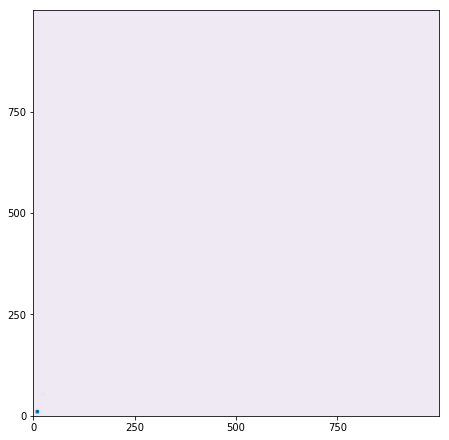

In [2]:
%%cython -a
# from cythonic.core.queen cimport queen
from cythonic.core.domain cimport domain
from cythonic.core.ant cimport Ant
from cythonic.plugins.positions cimport point, ant_state
from cythonic.plugins.rng cimport RNG
from cythonic.plugins.functions cimport deg
from cython.parallel cimport prange
from entropy.core.visualization import StigmergyPlot, Plotter
from libc.math cimport M_PI, cos as ccos, sin as csin
import numpy as np
cimport numpy as cnp
cimport cython

ctypedef Ant c_ant

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
cdef class ext_ant(Ant):
    cdef readonly  set_state(self, point pos, double teta, double t,
                            double rng_time, bint foodbound ):
        self._pos = pos
        self._azimuth = teta
        self.time = t
        self.rng_time = rng_time
#             bint foodbound # flag for foodbound (alternative nestbound)
#     bint out_of_bounds # flag for being out of bounds
#     bint active # flag for being active in the simulation
#     double _azimuth # theta [degrees]
#     double v # ant speed [mm/s]
#     point _pos # ant position [x,y] in [mm]
#     double rng_time #timer for the random number generator
#     double time # timer for state based drop quantity

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.initializedcheck(False)
cdef class queen():
    " wrapper for the ant class, difficulties casting list of ants to c-objects :("
    cdef list ants
    cdef unsigned int n
    cdef unsigned int count_active

    def __cinit__(self,long n):
        self.n = n
        self.ants = []
        self.count_active = 0
        self.deploy()

    cpdef void deploy(self, ):
        ant_dict = {'speed' : 10, 'gain' : 2, 'l' : 5, 'sens_offset' : 45,
          'limits' :np.array([10,10],dtype=np.float_),'q' : 1.5, 'return_factor' :1,
          'drop_fun' : 'exp_decay', 'drop_beta' : .5, 'rng_gamma':2}
        cdef int i
        cdef Ant a
        for i in range(self.n):
            a = Ant(id = i,**ant_dict)
            self.ants.append(a)

    cdef readonly void activate(self, ant_state s):
        " activate next ant "
        cdef c_ant a
        a = self.ants[self.count_active]
        a.activate(s)
        self.count_active+=1


    cpdef void reverse(self):
        for ant in self.ants:
            if ant.active:
                ant.reverse()

    cpdef void gradient_step(self,double dt, str observe_fun, double[:] Q):
        "Gradient step wrapper"
        cdef c_ant a
        for ant in self.ants:
            a = ant
            if a.active:
                a.gradient_step(dt,observe_fun,Q)
                ant = a

    cpdef void observe_pheromone(self,str observe_fun, double[:] Q):
        "observe pheromone wrapper"
        # print(Q)eposit quantity time constant
        cdef unsigned int i
        for i in range(self.n):
            with self.ants[i] as ant:
                if ant.active:
                    ant.observe_pheromone(observe_fun,Q[i])

cdef double pitch = 2
cdef double[2] limits = np.array([1000,1000],dtype=np.float_)
cdef double[2] size = limits, nest = np.array([25.,50.]), food = np.array([75.,50.])
cdef double R=5.

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.initializedcheck(False)
cdef class sim_controller():
    cdef domain dom
    cdef queen controller
    cdef double[:] Q_map #pheromone volume under left and right antenna:  [Qleft, Qright]
    cdef double[:,::1] ant_xy_theta
    cdef double[::1] ant_q
    cdef double Q_deposit, t #deposit pheromone volume
    cdef unsigned int n_agents
    cdef str sens_fun, deploy_location
    cdef double[:] deploy_time
    cdef unsigned int i
    cdef RNG rng
    
    def __cinit__(self, dom_dict, ant_dict,sim_dict):
        print('--init--')
        self.dom = domain(**dom_dict)
        self.Q_map = np.zeros([2],dtype= np.float_)
        self.Q_deposit = 1e3
        self.start_sim(**sim_dict)
        self.i=0
        self.rng = RNG()
        
    cdef void make_deploy_time(self,str method):
        if method == 'instant':
            self.deploy_time = np.zeros(self.n_agents,dtype=np.float_)
    
    cdef void evaporate(self):
        self.dom.pyvaporate()
            
    cdef void cevaporate(self):
        self.dom.cvaporate()
        
    @property
    def xs(self):
        return np.array(self.ant_xy_theta[:,0])
    @property
    def ys(self):
        return np.array(self.ant_xy_theta[:,1])
    @property
    def thetas(self):
        return np.array(self.ant_xy_theta[:,2])
        
    cdef void store(self,unsigned int* i, point* p, double* theta):
        " store position and orientation of all ants in a long np.ndarray "
        self.ant_xy_theta[i[0],0] = p[0].x
        self.ant_xy_theta[i[0],1] = p[0].y
        self.ant_xy_theta[i[0],2] =  theta[0]
        
    cdef ant_state deploy_pos(self,):
        cdef ant_state x
        if self.deploy_location =='nest':
            x.theta = self.rng.rand()*M_PI*2
            x.x  =self.dom.nest_location.x + ccos(x.theta)*self.dom.nest_radius
            x.y  =self.dom.nest_location.y+csin(x.theta)*self.dom.nest_radius
            x.theta=deg(&x.theta)
        return x
            
    cdef void activate(self,double *dt):
        "activate more agents"
        print(f'needed are {self.n_agents} agents')
        print(f'{self.controller.count_active} active ants')
        n = np.sum(np.array(self.deploy_time)<self.t+dt[0])-self.controller.count_active
        for i in range(n):
            self.controller.activate(self.deploy_pos())
        
    cdef void gradient_step(self,double dt):
        " first activate agents if necessary, then do a differential sensing step "
        cdef unsigned int n,i
        cdef c_ant a
        if self.controller.count_active < self.n_agents:
            self.activate(&dt)
        cdef point x
        for i in range(self.controller.count_active):
            a = self.controller.ants[i] #with self.controller.ants[i] as ant:
            self.Q_map[0] = self.dom.probe_pheromone(&a._left)
            self.Q_map[1] = self.dom.probe_pheromone(&a._right)
            self.ant_q[i] = a.return_drop_quantity(&dt) #store deposited pheromone in array for all ants
            self.store(&self.i, &a._pos, &a._azimuth)
            print(f' ant at {a._pos} drops {self.ant_q[i]} pheromone')
            self.dom.add_pheromone(p=&a._pos,Q= &self.ant_q[i])
            self.controller.gradient_step(dt,self.sens_fun,self.Q_map)
            print(a._pos)
        self.cevaporate()
#         self.evaporate() #slower than cevaporate()
        self.t+=dt
        
    def start_sim(self,unsigned int n_agents, double sigma,str sens_function, str deploy_location,
                  double target_pheromone_volume, str deploy_method):
        " Make the sim environment, determine when ants are to deployed "
        " prepare sim "
        self.n_agents = n_agents
        self.ant_xy_theta = np.zeros((n_agents,3),dtype=np.float_)
        self.ant_q = np.zeros(n_agents, dtype = np.float_)
        self.sens_fun = sens_function
        self.deploy_location = deploy_location
        self.make_deploy_time(deploy_method)
        
        " prepare domain "
        self.dom.init_gaussian(significancy=1e2, sigma=sigma)
        self.dom.set_target_pheromone(target_pheromone_volume)
        self.dom.cvaporate() #start with the correct amount of pheromone
        
        " prepare ant controller (queen) "
        self.controller = queen(self.n_agents)

dom_settings = {'size':size, 'pitch': pitch, 'nest_loc': nest, 'food_loc':food,
                'nest_rad':R, 'food_rad': R}
ant_dict = {'speed' : 10, 'gain' : 2, 'l' : 5, 'sens_offset' : 45,
          'limits' :np.array(limits),'q' : 1.5, 'return_factor' :1,
          'drop_fun' : 'exp_decay', 'drop_beta' : .05, 'rng_gamma':2}
sim_dict = {'n_agents': 20, 'sigma': 3, 'sens_function':'linear','deploy_location':'nest',
           'target_pheromone_volume':1000.,'deploy_method':'instant'}
cdef sim_controller sim = sim_controller(dom_dict = dom_settings, ant_dict = ant_dict, sim_dict = sim_dict)

from time import time


cdef point P
cdef double q = 1e2
cdef unsigned int step, steps = 2
sim.dom.init_gaussian(significancy=1e2, sigma=3)
print(f"Max of map == {sim.dom.Map.max()}, sum == {sim.dom.Map.sum()}")
cdef double tic, toc, steptime
tic = time()
for step in range(steps):
    sim.gradient_step(.05)
toc = time()
steptime=toc-tic
print(f"Max of map == {sim.dom.Map.max()}, sum == {sim.dom.Map.sum()}")
print(f"step took {steptime*1000/steps} msec")
print("\n\n\n")


vis = Plotter(sim.dom.Map, shown='stigmergy')
vis.draw_stigmergy(sim.dom.Map.map)
vis.show()

# def timet():
#     cdef double toc,tic, t_npy,t_c
#     cdef unsigned int i,N =20
#     tic = time()
#     for i in range(N):
#         sim.evaporate()
#     toc = time()
#     t_npy = toc-tic
#     print(f"Evaporate took {t_npy*1000/N} msec")
#     tic = time()
#     for i in range(N):
#         sim.cevaporate()
#     toc = time()
#     t_c=toc-tic
#     print(f"C-Evaporate took {t_c*1000/N} msec ")
#     print(np.array(sim.dom.Map.map).sum())
#     print(f"C is {t_npy/t_c} times faster")

#     N=<long>1e1
#     cdef double x = 0
#     tic = time()
#     for i in range(N):
#         x = sim.dom.Map.max()
# #         x = sim.ccmax()
#     toc = time()
#     t_c=toc-tic
#     print(f"C-max took {t_c*1000/N} msec ")
#     tic = time()
#     for i in range(N):
#         x = np.array(sim.dom.Map.map).max()
#     toc = time()
#     t_npy = toc-tic
#     print(f"Py-max took {t_npy*1000/N} msec ")
#     print(f"C-max is {t_npy/t_c} times faster")
#     print('--done--')
# timet()
# print('6')
# print(sim.xs)
# print(sim.ys)
# print(sim.thetas)

In [16]:
import numpy as np
x = np.zeros(2,dtype=np.float_)
print(x)

cdef extern from "T1.h" :
cdef cppclass Tree:
Tree(int name)
ctypedef Tree* Tree_ptr # <--- ctypedef declared here.
cdef cppclass B:
B(int name)
list[Tree_ptr]* getListPointer()


[0. 0.]


In [8]:
%%cython -a
# distutils: language = c++
from libcpp.vector cimport vector
from cythonic.core.ant cimport Ant
cdef struct xy:
    double x
    double y
cdef unsigned int x = 10
cdef vector[xy] a
